##**Практическое задание 6**

##**Задание 1**

In [26]:
# Обновляем список пакетов в системе
!apt-get update -y

# Устанавливаем необходимые компоненты для работы с OpenCL:
# ocl-icd-opencl-dev - ICD-лоадер OpenCL (позволяет работать с разными OpenCL-драйверами)
# opencl-headers     - заголовочные файлы OpenCL для компиляции программ
# clinfo             - утилита для проверки доступных OpenCL-платформ и устройств
# pocl-opencl-icd    - реализация OpenCL на CPU (Portable OpenCL), используется в среде Colab
!apt-get install -y ocl-icd-opencl-dev opencl-headers clinfo pocl-opencl-icd

# Выводим информацию о доступных OpenCL-платформах и устройствах
!clinfo | head -n 60


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,970 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,640 kB]
Get:14 http://archive.ubuntu.c

In [2]:
%%writefile kernel.cl
// Объявление ядра OpenCL с именем vector_add
__kernel void vector_add(
    __global const float* A,   // Указатель на первый входной массив A в глобальной памяти
    __global const float* B,   // Указатель на второй входной массив B в глобальной памяти
    __global float* C,         // Указатель на выходной массив C для хранения результата
    const int N                // Размер массивов (количество элементов)
)
{
    // Получаем глобальный идентификатор текущего work-item
    int id = get_global_id(0);

    // Проверяем, что индекс не выходит за границы массива
    if (id < N) {

        // Выполняем поэлементное сложение массивов A и B
        // и записываем результат в массив C
        C[id] = A[id] + B[id];
    }
}

Writing kernel.cl


In [11]:
%%writefile vadd_cuda.cu

#include <iostream>                      // Подключаем ввод/вывод (cout)
#include <vector>                        // Подключаем std::vector для массивов
#include <random>                        // Подключаем генерацию случайных чисел
#include <cuda_runtime.h>                // Подключаем CUDA Runtime API

using namespace std;                     // Используем пространство имён std

// Макрос для проверки ошибок CUDA
#define CUDA_CHECK(x) do {               \
  cudaError_t e = (x);                   \
  if (e != cudaSuccess) {                \
    cout << "CUDA error: "               \
         << cudaGetErrorString(e)        \
         << " at " << __FILE__ << ":"    \
         << __LINE__ << "\n";            \
    exit(1);                             \
  }                                      \
} while(0)

// CUDA-ядро для поэлементного сложения двух массивов
__global__ void vecAdd(const float* A,   // Указатель на массив A в памяти GPU
                       const float* B,   // Указатель на массив B в памяти GPU
                       float* C,         // Указатель на массив C (результат) в памяти GPU
                       int N) {           // Размер массивов

    // Вычисляем глобальный индекс потока
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    // Проверяем, что индекс не выходит за границы массива
    if (i < N)
        C[i] = A[i] + B[i];               // Складываем элементы A и B и записываем в C
}

// Функция для измерения среднего времени выполнения CUDA-ядра
static float avgKernelTime(const float* dA, // Указатель на массив A в памяти GPU
                           const float* dB, // Указатель на массив B в памяти GPU
                           float* dC,       // Указатель на массив C в памяти GPU
                           int N,            // Размер массивов
                           int blockSize,    // Размер блока потоков
                           int iterations) { // Количество запусков для усреднения

    // Определяем размер блока (blockSize потоков)
    dim3 block(blockSize);

    // Определяем размер сетки (grid), чтобы покрыть N элементов
    dim3 grid((N + block.x - 1) / block.x);

    // Прогревочный запуск ядра (не учитывается во времени)
    vecAdd<<<grid, block>>>(dA, dB, dC, N);   // Запуск CUDA-ядра
    CUDA_CHECK(cudaGetLastError());           // Проверка ошибок запуска
    CUDA_CHECK(cudaDeviceSynchronize());      // Ожидание завершения ядра

    // Создаём CUDA-события для измерения времени
    cudaEvent_t e1, e2;
    CUDA_CHECK(cudaEventCreate(&e1));         // Событие начала
    CUDA_CHECK(cudaEventCreate(&e2));         // Событие конца

    float totalMs = 0.0f;                     // Переменная для суммарного времени

    // Цикл многократного запуска ядра
    for (int it = 0; it < iterations; ++it) {

        CUDA_CHECK(cudaEventRecord(e1));      // Фиксируем время начала

        vecAdd<<<grid, block>>>(dA, dB, dC, N); // Запускаем ядро
        CUDA_CHECK(cudaGetLastError());       // Проверяем ошибки запуска

        CUDA_CHECK(cudaEventRecord(e2));      // Фиксируем время окончания
        CUDA_CHECK(cudaEventSynchronize(e2)); // Ждём завершения ядра

        float ms = 0.0f;                      // Переменная для времени одного запуска
        CUDA_CHECK(cudaEventElapsedTime(&ms, e1, e2)); // Вычисляем время в миллисекундах
        totalMs += ms;                        // Добавляем время к сумме
    }

    CUDA_CHECK(cudaEventDestroy(e1));         // Удаляем событие начала
    CUDA_CHECK(cudaEventDestroy(e2));         // Удаляем событие конца

    return totalMs / iterations;              // Возвращаем среднее время выполнения ядра
}

// Главная функция программы
int main() {

    const int N = 1'000'000;                  // Размер массивов
    const int iterations = 500;               // Количество запусков ядра
    const int blockSize = 256;                // Размер блока потоков
    const int gridX = (N + blockSize - 1) / blockSize; // Количество блоков по X

    // Объявляем массивы на стороне CPU
    vector<float> A(N), B(N), C(N);

    // Генератор случайных чисел
    mt19937 gen(42);

    // Распределение случайных чисел
    uniform_real_distribution<float> dist(0.0f, 100.0f);

    // Заполняем массивы A и B случайными значениями
    for (int i = 0; i < N; ++i) {
        A[i] = dist(gen);
        B[i] = dist(gen);
    }

    // Указатели на массивы в памяти GPU
    float *dA = nullptr, *dB = nullptr, *dC = nullptr;

    // Выделяем память на GPU под массив A
    CUDA_CHECK(cudaMalloc(&dA, N * sizeof(float)));

    // Выделяем память на GPU под массив B
    CUDA_CHECK(cudaMalloc(&dB, N * sizeof(float)));

    // Выделяем память на GPU под массив C
    CUDA_CHECK(cudaMalloc(&dC, N * sizeof(float)));

    // Копируем массив A с CPU на GPU
    CUDA_CHECK(cudaMemcpy(dA, A.data(), N * sizeof(float),
                           cudaMemcpyHostToDevice));

    // Копируем массив B с CPU на GPU
    CUDA_CHECK(cudaMemcpy(dB, B.data(), N * sizeof(float),
                           cudaMemcpyHostToDevice));

    // Измеряем среднее время выполнения CUDA-ядра
    float avgMs = avgKernelTime(dA, dB, dC, N, blockSize, iterations);

    // Копируем результат из GPU обратно на CPU
    CUDA_CHECK(cudaMemcpy(C.data(), dC, N * sizeof(float),
                           cudaMemcpyDeviceToHost));

    // Структура для хранения информации о GPU
    cudaDeviceProp prop{};

    // Получаем свойства GPU (устройство 0)
    CUDA_CHECK(cudaGetDeviceProperties(&prop, 0));

    // Выводим информацию о выполнении
    cout << "GPU(CUDA)\n";                    // Тип вычислений
    cout << "Platform: NVIDIA CUDA\n";        // Платформа
    cout << "Device: " << prop.name << "\n";  // Название GPU
    cout << "N=" << N << ", iterations=" << iterations << "\n"; // Параметры
    cout << "Avg kernel time: " << avgMs << " ms\n"; // Среднее время ядра
    cout << "Global size: " << (size_t)gridX * (size_t)blockSize // Общее число потоков
         << ", Local size: " << blockSize << "\n"; // Размер блока

    // Освобождаем память GPU
    CUDA_CHECK(cudaFree(dA));
    CUDA_CHECK(cudaFree(dB));
    CUDA_CHECK(cudaFree(dC));

    return 0;                                 // Завершаем программу
}

Overwriting vadd_cuda.cu


In [13]:
%%writefile vadd_opencl.cpp
#define CL_TARGET_OPENCL_VERSION 200            // Указываем целевую версию OpenCL API (2.0), чтобы заголовки компилились без лишних предупреждений

#include <CL/cl.h>                               // Подключаем OpenCL API (типы данных и функции)
#include <iostream>                              // Подключаем ввод/вывод (cout)
#include <vector>                                // Подключаем std::vector для массивов
#include <fstream>                               // Подключаем чтение файлов (ifstream)
#include <random>                                // Подключаем генерацию случайных чисел
#include <string>                                // Подключаем std::string

using namespace std;                             // Используем std без префикса

static void die(cl_int err, const char* msg) {   // Функция: проверяет код ошибки OpenCL и завершает программу при ошибке
    if (err != CL_SUCCESS) {                     // Если код ошибки не равен CL_SUCCESS
        cout << "OpenCL error: " << msg          // Выводим текст "OpenCL error:" и описание места ошибки
             << " (" << err << ")\n";            // Выводим код ошибки в скобках и перевод строки
        exit(1);                                 // Завершаем программу с кодом 1
    }                                            // Конец проверки
}                                                // Конец функции die

static string loadText(const string& path) {     // Функция: загружает текст файла по пути path и возвращает его как строку
    ifstream f(path);                            // Открываем файл для чтения
    if (!f) {                                    // Если файл не открылся
        cout << "Cannot open file: " << path     // Выводим сообщение об ошибке открытия файла
             << "\n";                            // Перевод строки
        exit(1);                                 // Завершаем программу
    }                                            // Конец проверки открытия
    return string((istreambuf_iterator<char>(f)),// Считываем файл в строку через итераторы (начало)
                  istreambuf_iterator<char>());  // Считываем файл в строку через итераторы (конец)
}                                                // Конец функции loadText

static string getPlatName(cl_platform_id p) {    // Функция: получает имя OpenCL-платформы
    char buf[256] = {0};                         // Буфер для строки имени платформы (обнуляем)
    clGetPlatformInfo(p, CL_PLATFORM_NAME,       // Запрашиваем у OpenCL строку с названием платформы
                      sizeof(buf), buf, nullptr);// Передаём размер буфера и куда записать результат
    return string(buf);                          // Возвращаем имя платформы как std::string
}                                                // Конец функции getPlatName

static string getDevName(cl_device_id d) {       // Функция: получает имя OpenCL-устройства
    char buf[256] = {0};                         // Буфер для строки имени устройства (обнуляем)
    clGetDeviceInfo(d, CL_DEVICE_NAME,           // Запрашиваем у OpenCL строку с названием устройства
                    sizeof(buf), buf, nullptr);  // Передаём размер буфера и куда записать результат
    return string(buf);                          // Возвращаем имя устройства как std::string
}                                                // Конец функции getDevName

int main() {                                     // Главная функция программы
    const int N = 1'000'000;                     // Количество элементов в массивах A, B, C
    const int iterations = 200;                  // Количество запусков ядра для усреднения времени
    const size_t localSize = 256;                // Локальный размер work-group (сколько work-item в группе)
    const size_t globalSize =                    // Глобальный размер NDRange (общее число work-item)
        ((N + localSize - 1) / localSize) * localSize; // Округляем вверх до кратности localSize, чтобы покрыть N

    vector<float> A(N), B(N), C(N);              // Создаём массивы на стороне CPU
    mt19937 gen(42);                             // Генератор случайных чисел (фиксированный seed для повторяемости)
    uniform_real_distribution<float> dist(0.0f, 100.0f); // Диапазон случайных значений [0; 100]
    for (int i = 0; i < N; ++i) {                // Заполняем массивы A и B
        A[i] = dist(gen);                        // Записываем случайное число в A[i]
        B[i] = dist(gen);                        // Записываем случайное число в B[i]
    }                                            // Конец заполнения

    cl_int err;                                  // Переменная для хранения кода ошибок OpenCL

    cl_uint numPlatforms = 0;                    // Переменная: количество OpenCL платформ
    die(clGetPlatformIDs(0, nullptr,             // Первый вызов: только узнаём количество платформ
                         &numPlatforms),         // OpenCL запишет сюда число платформ
        "clGetPlatformIDs(count)");              // Сообщение для die() если ошибка

    vector<cl_platform_id> platforms(numPlatforms);// Вектор для хранения идентификаторов платформ
    die(clGetPlatformIDs(numPlatforms,            // Второй вызов: получаем сами ID платформ
                         platforms.data(),        // Куда записать ID платформ
                         nullptr),                // Не нужно возвращать количество ещё раз
        "clGetPlatformIDs(list)");                // Сообщение для die() если ошибка

    cl_platform_id platform = nullptr;           // Переменная для выбранной платформы (пока не выбрана)
    cl_device_id device = nullptr;               // Переменная для выбранного устройства (пока не выбрано)

    for (auto p : platforms) {                   // Перебираем все платформы
        cl_uint numDevs = 0;                     // Количество CPU устройств на текущей платформе
        err = clGetDeviceIDs(p, CL_DEVICE_TYPE_CPU,// Запрашиваем CPU устройства
                             0, nullptr, &numDevs);// Сначала только узнаём количество устройств
        if (err == CL_SUCCESS && numDevs > 0) {  // Если всё ок и устройства есть
            vector<cl_device_id> devs(numDevs);  // Создаём вектор для ID устройств
            die(clGetDeviceIDs(p, CL_DEVICE_TYPE_CPU,// Получаем список CPU устройств
                               numDevs, devs.data(), nullptr),
                "clGetDeviceIDs(CPU)");          // Сообщение для die() если ошибка
            platform = p;                        // Сохраняем платформу, где нашли CPU устройство
            device = devs[0];                    // Берём первое найденное CPU устройство
            break;                               // Выходим из цикла, т.к. устройство уже найдено
        }                                        // Конец if
    }                                            // Конец цикла по платформам

    if (!device) {                               // Если CPU устройство не найдено
        cout << "CPU(OpenCL)\n";                 // Печатаем заголовок
        cout << "Platform: not found\n";         // Сообщаем, что платформа не найдена
        cout << "Device:\n";                     // Печатаем пустую строку устройства (как в твоём формате)
        cout << "N=" << N << ", iterations="     // Печатаем параметры задачи
             << iterations << "\n";              // Печатаем количество итераций
        cout << "Avg kernel time: 0 ms\n";       // Время 0, потому что ядро не запускали
        cout << "Global size: " << globalSize    // Печатаем рассчитанный global size
             << ", Local size: " << localSize    // Печатаем local size
             << "\n";                            // Перевод строки
        return 0;                                // Завершаем программу
    }                                            // Конец блока “если устройства нет”

    string platName = getPlatName(platform);     // Получаем имя платформы
    string devName  = getDevName(device);        // Получаем имя устройства

    cl_context context =                          // Создаём OpenCL контекст
        clCreateContext(nullptr,                  // Без специальных свойств контекста
                        1, &device,               // Контекст для 1 устройства (device)
                        nullptr, nullptr,         // Без callback для ошибок
                        &err);                    // OpenCL запишет код ошибки сюда
    die(err, "clCreateContext");                  // Проверяем, что контекст создан

    const cl_queue_properties props[] = {         // Список свойств для командной очереди
        CL_QUEUE_PROPERTIES,                      // Ключ свойства "properties"
        (cl_queue_properties)CL_QUEUE_PROFILING_ENABLE, // Включаем профилирование (тайминг через события)
        0                                         // Терминатор списка свойств
    };                                            // Конец массива props

    cl_command_queue queue =                      // Создаём командную очередь
        clCreateCommandQueueWithProperties(       // Новая функция (OpenCL 2.0+), не deprecated
            context, device, props, &err);        // Передаём контекст, устройство, свойства, получаем err
    die(err, "clCreateCommandQueueWithProperties");// Проверяем, что очередь создана

    string srcStr = loadText("kernel.cl");        // Читаем файл kernel.cl в строку
    const char* src = srcStr.c_str();             // Получаем указатель на C-строку (нужно для OpenCL API)
    size_t srcLen = srcStr.size();                // Длина исходного кода ядра

    cl_program program =                          // Создаём OpenCL программу из исходного кода
        clCreateProgramWithSource(context,        // Контекст
                                  1,              // Количество строк-исходников (1)
                                  &src,           // Указатель на исходник
                                  &srcLen,        // Длина исходника
                                  &err);          // Код ошибки
    die(err, "clCreateProgramWithSource");        // Проверяем создание программы

    err = clBuildProgram(program,                 // Компилируем программу
                         1, &device,              // Под 1 устройство
                         nullptr, nullptr, nullptr);// Без опций/колбэков
    if (err != CL_SUCCESS) {                      // Если сборка не удалась
        size_t logSize = 0;                       // Размер лога компиляции
        clGetProgramBuildInfo(program, device,    // Запрашиваем размер лога
                              CL_PROGRAM_BUILD_LOG, 0, nullptr, &logSize);
        string log(logSize, '\0');                // Создаём строку для лога
        clGetProgramBuildInfo(program, device,    // Получаем сам лог
                              CL_PROGRAM_BUILD_LOG, logSize, log.data(), nullptr);
        cout << log << "\n";                      // Выводим лог, чтобы увидеть причину ошибки
        die(err, "clBuildProgram");               // Завершаем программу, т.к. ядро не собрано
    }                                             // Конец обработки ошибки сборки

    cl_kernel kernel =                            // Создаём ядро (kernel object)
        clCreateKernel(program, "vector_add", &err);// Имя функции в kernel.cl должно быть vector_add
    die(err, "clCreateKernel");                   // Проверяем создание ядра

    cl_mem dA = clCreateBuffer(context,           // Создаём буфер в памяти устройства для массива A
                              CL_MEM_READ_ONLY |  // Буфер только для чтения на устройстве
                              CL_MEM_COPY_HOST_PTR,// И сразу копируем данные с хоста
                              N * sizeof(float),  // Размер буфера
                              A.data(),           // Указатель на данные A на хосте
                              &err);              // Код ошибки
    die(err, "buffer A");                         // Проверяем создание буфера A

    cl_mem dB = clCreateBuffer(context,           // Создаём буфер в памяти устройства для массива B
                              CL_MEM_READ_ONLY |  // Только чтение
                              CL_MEM_COPY_HOST_PTR,// Копирование данных с хоста
                              N * sizeof(float),  // Размер
                              B.data(),           // Данные B
                              &err);              // Код ошибки
    die(err, "buffer B");                         // Проверяем создание буфера B

    cl_mem dC = clCreateBuffer(context,           // Создаём буфер в памяти устройства для результата C
                              CL_MEM_WRITE_ONLY,  // Только запись (результат)
                              N * sizeof(float),  // Размер
                              nullptr,            // Данных на хосте не передаём
                              &err);              // Код ошибки
    die(err, "buffer C");                         // Проверяем создание буфера C

    die(clSetKernelArg(kernel, 0,                 // Устанавливаем аргумент ядра №0
                       sizeof(cl_mem), &dA),      // Передаём буфер A
        "arg0");                                  // Сообщение для die()

    die(clSetKernelArg(kernel, 1,                 // Аргумент ядра №1
                       sizeof(cl_mem), &dB),      // Передаём буфер B
        "arg1");                                  // Сообщение для die()

    die(clSetKernelArg(kernel, 2,                 // Аргумент ядра №2
                       sizeof(cl_mem), &dC),      // Передаём буфер C (результат)
        "arg2");                                  // Сообщение для die()

    die(clSetKernelArg(kernel, 3,                 // Аргумент ядра №3
                       sizeof(int), &N),          // Передаём размер N
        "arg3");                                  // Сообщение для die()

    clEnqueueNDRangeKernel(queue, kernel, 1,      // Прогревочный запуск ядра (warm-up)
                           nullptr,               // global offset не используем
                           &globalSize,           // global size (сколько work-item всего)
                           &localSize,            // local size (work-group size)
                           0, nullptr, nullptr);  // Без ожиданий и без события
    clFinish(queue);                               // Ждём завершения прогрева

    double sumMs = 0.0;                           // Сумма времени всех запусков (в мс)

    for (int i = 0; i < iterations; ++i) {        // Запускаем ядро много раз для усреднения
        cl_event ev;                              // Событие OpenCL для профилирования

        die(clEnqueueNDRangeKernel(queue, kernel, 1, // Запуск ядра и сохранение события
                                   nullptr, &globalSize, &localSize,
                                   0, nullptr, &ev),
            "enqueue");                            // Сообщение для die()

        clWaitForEvents(1, &ev);                   // Ждём завершения работы ядра (по событию)

        cl_ulong t0 = 0, t1 = 0;                   // Временные метки start/end (наносекунды)

        clGetEventProfilingInfo(ev,                // Получаем время начала выполнения команды
                                CL_PROFILING_COMMAND_START,
                                sizeof(t0), &t0, nullptr);

        clGetEventProfilingInfo(ev,                // Получаем время окончания выполнения команды
                                CL_PROFILING_COMMAND_END,
                                sizeof(t1), &t1, nullptr);

        sumMs += (t1 - t0) * 1e-6;                 // Переводим ns -> ms и добавляем к сумме
        clReleaseEvent(ev);                        // Освобождаем событие
    }                                              // Конец цикла измерений

    double avgMs = sumMs / iterations;             // Среднее время выполнения ядра (мс)

    clEnqueueReadBuffer(queue, dC, CL_TRUE, 0,     // Считываем результат из буфера dC на хост
                        N * sizeof(float),         // Сколько байт читаем
                        C.data(),                  // Куда записать на CPU
                        0, nullptr, nullptr);      // Без событий/зависимостей

    cout << "CPU(OpenCL)\n";                       // Печатаем тип устройства (CPU через OpenCL)
    cout << "Platform: " << platName << "\n";      // Печатаем имя платформы
    cout << "Device: " << devName << "\n";         // Печатаем имя устройства
    cout << "N=" << N << ", iterations="           // Печатаем N и число итераций
         << iterations << "\n";                    // Перевод строки
    cout << "Avg kernel time: " << avgMs           // Печатаем среднее время
         << " ms\n";                               // Единицы измерения и перевод строки
    cout << "Global size: " << globalSize          // Печатаем global size
         << ", Local size: " << localSize << "\n"; // Печатаем local size

    clReleaseMemObject(dA);                        // Освобождаем буфер A на устройстве
    clReleaseMemObject(dB);                        // Освобождаем буфер B на устройстве
    clReleaseMemObject(dC);                        // Освобождаем буфер C на устройстве
    clReleaseKernel(kernel);                       // Освобождаем объект ядра
    clReleaseProgram(program);                     // Освобождаем программу
    clReleaseCommandQueue(queue);                  // Освобождаем командную очередь
    clReleaseContext(context);                     // Освобождаем контекст

    return 0;                                      // Успешное завершение программы
}                                                  // Конец main

Overwriting vadd_opencl.cpp


In [14]:
!g++ vadd_opencl.cpp -O2 -lOpenCL -o vadd_cpu
!./vadd_cpu

CPU(OpenCL)
Platform: Portable Computing Language
Device: pthread-Intel(R) Xeon(R) CPU @ 2.00GHz
N=1000000, iterations=200
Avg kernel time: 0.489705 ms
Global size: 1000192, Local size: 256


In [12]:
!nvcc -O3 -arch=sm_75 vadd_cuda.cu -o vadd_gpu
!./vadd_gpu

GPU(CUDA)
Platform: NVIDIA CUDA
Device: Tesla T4
N=1000000, iterations=500
Avg kernel time: 0.0517043 ms
Global size: 1000192, Local size: 256


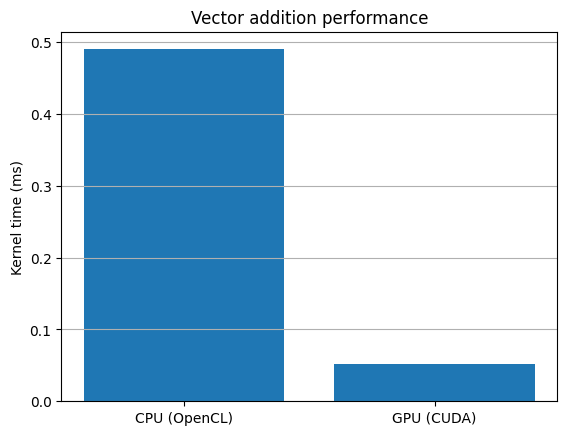

In [15]:
import matplotlib.pyplot as plt

cpu_ms = 0.489705
gpu_ms = 0.0517043

labels = ['CPU (OpenCL)', 'GPU (CUDA)']
times = [cpu_ms, gpu_ms]

plt.bar(labels, times)
plt.ylabel('Kernel time (ms)')
plt.title('Vector addition performance')
plt.grid(axis='y')
plt.show()

##**Вывод**

В рамках данного задания была реализована программа поэлементного сложения двух массивов размером 1 000 000 элементов и выполнено сравнение производительности вычислений на CPU и GPU.

Для выполнения на CPU использовалась технология OpenCL с реализацией на базе Portable Computing Language. Среднее время выполнения ядра при 200 итерациях составило 0.490 мс. Несмотря на параллельное выполнение, производительность ограничена архитектурой CPU и относительно небольшим количеством аппаратных вычислительных потоков.

Для выполнения на GPU применялась технология CUDA на видеокарте NVIDIA Tesla T4. Среднее время выполнения ядра при 500 итерациях составило 0.052 мс, что значительно меньше по сравнению с CPU. Это обусловлено высокой степенью параллелизма GPU и более высокой пропускной способностью памяти.

Сравнение результатов показывает, что GPU выполняет задачу поэлементного сложения примерно в 9–10 раз быстрее, чем CPU. Полученные результаты подтверждают, что графические процессоры значительно эффективнее для простых, хорошо параллелизуемых операций над большими массивами данных.

Таким образом, использование GPU является более предпочтительным решением для задач массовых вычислений, особенно при обработке больших объёмов данных.

##**Задание 2**

In [27]:
%%writefile kernel.cl

__kernel void matmul(                       // Объявляем OpenCL-ядро с именем matmul
    __global const float* A,                // Указатель на матрицу A в глобальной памяти (только чтение)
    __global const float* B,                // Указатель на матрицу B в глобальной памяти (только чтение)
    __global float* C,                      // Указатель на матрицу C в глобальной памяти (результат)
    const int N,                            // Количество строк матрицы A и C
    const int M,                            // Количество столбцов матрицы A и строк матрицы B
    const int K                             // Количество столбцов матрицы B и C
){                                          // Начало тела ядра

    int col = get_global_id(0);             // Получаем глобальный идентификатор по оси X (номер столбца C)
    int row = get_global_id(1);             // Получаем глобальный идентификатор по оси Y (номер строки C)

    if (row < N && col < K) {               // Проверяем, что текущий элемент находится внутри матрицы C

        float acc = 0.0f;                   // Инициализируем аккумулятор для суммы произведений

        for (int k = 0; k < M; k++) {       // Цикл по общей размерности M
            acc += A[row * M + k]            // Берём элемент A из строки row и столбца k
                 * B[k * K + col];           // Берём элемент B из строки k и столбца col и умножаем
        }                                   // Конец цикла по k

        C[row * K + col] = acc;             // Записываем вычисленный элемент в матрицу C
    }                                       // Конец проверки границ

}                                           // Конец ядра


Overwriting kernel.cl


In [29]:
%%writefile matmul_opencl.cpp

#define CL_TARGET_OPENCL_VERSION 120           // Указываем целевую версию OpenCL (1.2)

#include <CL/cl.h>                             // Подключаем OpenCL API
#include <iostream>                            // Ввод и вывод (cout, cerr)
#include <vector>                              // Контейнер vector
#include <fstream>                             // Работа с файлами
#include <cmath>                               // Математические функции (fabs)
#include <chrono>                              // Измерение времени

// Макрос для проверки ошибок OpenCL

#define CHECK(err) do {                                   \
    if ((err) != CL_SUCCESS) {                            \
        std::cerr << "OpenCL error: " << (err)            \
                  << std::endl;                           \
        exit(1);                                          \
    }                                                     \
} while (0)


void cpu_matmul(const std::vector<float>& A,   // Матрица A (N×M)
                const std::vector<float>& B,   // Матрица B (M×K)
                std::vector<float>& C,         // Матрица C (N×K)
                int N, int M, int K) {          // Размеры матриц
    for (int i = 0; i < N; i++) {               // Проход по строкам A и C
        for (int j = 0; j < K; j++) {           // Проход по столбцам B и C
            float sum = 0.0f;                   // Аккумулятор суммы
            for (int k = 0; k < M; k++) {       // Проход по общей размерности M
                sum += A[i * M + k]             // Элемент A[i][k]
                     * B[k * K + j];            // Элемент B[k][j]
            }
            C[i * K + j] = sum;                 // Записываем элемент C[i][j]
        }
    }
}

int main() {

    const int N = 256;                          // Число строк матрицы A и C
    const int M = 384;                          // Число столбцов A и строк B
    const int K = 192;                          // Число столбцов B и C

    std::vector<float> A(N * M),                // Матрица A
                       B(M * K),                // Матрица B
                       C(N * K),                // Результат OpenCL
                       C_cpu(N * K);            // Результат CPU

    for (auto& x : A)                           // Заполнение матрицы A
        x = static_cast<float>(rand()) / RAND_MAX;

    for (auto& x : B)                           // Заполнение матрицы B
        x = static_cast<float>(rand()) / RAND_MAX;

    auto t1 = std::chrono::high_resolution_clock::now(); // Начало замера CPU
    cpu_matmul(A, B, C_cpu, N, M, K);                     // Умножение матриц на CPU
    auto t2 = std::chrono::high_resolution_clock::now(); // Конец замера CPU

    std::cout << "CPU time: "
              << std::chrono::duration<double>(t2 - t1).count()
              << " s\n";

    cl_int err;                                 // Переменная для кода ошибок
    cl_platform_id platform;                    // OpenCL платформа
    cl_device_id device;                        // OpenCL устройство

    CHECK(clGetPlatformIDs(1, &platform, nullptr));               // Получаем первую платформу
    CHECK(clGetDeviceIDs(platform, CL_DEVICE_TYPE_ALL, 1,
                          &device, nullptr));                     // Получаем устройство

    cl_context context =                        // Создаём OpenCL контекст
        clCreateContext(nullptr, 1, &device,
                        nullptr, nullptr, &err);
    CHECK(err);

    cl_command_queue queue =                    // Создаём командную очередь
        clCreateCommandQueue(context, device,
                              0, &err);
    CHECK(err);

    std::string src = loadKernel("kernel.cl");  // Загружаем kernel.cl
    const char* source = src.c_str();           // Указатель на текст ядра
    size_t length = src.size();                 // Длина исходного кода

    cl_program program =                        // Создаём OpenCL программу
        clCreateProgramWithSource(context, 1,
                                  &source,
                                  &length, &err);
    CHECK(err);

    err = clBuildProgram(program, 1, &device,
                         nullptr, nullptr, nullptr);
    if (err != CL_SUCCESS) {                    // Проверка успешности компиляции
        size_t log_size;
        clGetProgramBuildInfo(program, device,
                               CL_PROGRAM_BUILD_LOG,
                               0, nullptr, &log_size);
        std::vector<char> log(log_size);
        clGetProgramBuildInfo(program, device,
                               CL_PROGRAM_BUILD_LOG,
                               log_size, log.data(), nullptr);
        std::cerr << log.data() << std::endl;
        exit(1);
    }

    cl_kernel kernel =                          // Создаём ядро matmul
        clCreateKernel(program, "matmul", &err);
    CHECK(err);

    cl_mem A_buf = clCreateBuffer(context,      // Буфер для матрицы A
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * A.size(), A.data(), &err);

    cl_mem B_buf = clCreateBuffer(context,      // Буфер для матрицы B
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * B.size(), B.data(), &err);

    cl_mem C_buf = clCreateBuffer(context,      // Буфер для матрицы C
        CL_MEM_WRITE_ONLY,
        sizeof(float) * C.size(), nullptr, &err);

    CHECK(err);

    CHECK(clSetKernelArg(kernel, 0, sizeof(cl_mem), &A_buf)); // Аргумент A
    CHECK(clSetKernelArg(kernel, 1, sizeof(cl_mem), &B_buf)); // Аргумент B
    CHECK(clSetKernelArg(kernel, 2, sizeof(cl_mem), &C_buf)); // Аргумент C
    CHECK(clSetKernelArg(kernel, 3, sizeof(int), &N));        // Аргумент N
    CHECK(clSetKernelArg(kernel, 4, sizeof(int), &M));        // Аргумент M
    CHECK(clSetKernelArg(kernel, 5, sizeof(int), &K));        // Аргумент K

    size_t global_size[2] = { (size_t)K, (size_t)N };         // Размер NDRange

    t1 = std::chrono::high_resolution_clock::now();           // Начало замера OpenCL
    CHECK(clEnqueueNDRangeKernel(queue, kernel, 2,
                                 nullptr, global_size,
                                 nullptr, 0,
                                 nullptr, nullptr));
    clFinish(queue);                                          // Ожидаем завершения
    t2 = std::chrono::high_resolution_clock::now();           // Конец замера OpenCL

    std::cout << "OpenCL time: "
              << std::chrono::duration<double>(t2 - t1).count()
              << " s\n";

    CHECK(clEnqueueReadBuffer(queue, C_buf, CL_TRUE, 0,
                              sizeof(float) * C.size(),
                              C.data(), 0,
                              nullptr, nullptr));             // Считываем результат

    float max_err = 0.0f;                                     // Максимальная ошибка
    for (size_t i = 0; i < C.size(); i++) {
        max_err = std::max(max_err,
                            std::fabs(C[i] - C_cpu[i]));
    }

    std::cout << "Max abs error: "
              << max_err << std::endl;

    clReleaseMemObject(A_buf);                                // Освобождаем буфер A
    clReleaseMemObject(B_buf);                                // Освобождаем буфер B
    clReleaseMemObject(C_buf);                                // Освобождаем буфер C
    clReleaseKernel(kernel);                                  // Освобождаем ядро
    clReleaseProgram(program);                                // Освобождаем программу
    clReleaseCommandQueue(queue);                             // Освобождаем очередь
    clReleaseContext(context);                                // Освобождаем контекст

    return 0;                                                 // Завершаем программу
}


Overwriting matmul_opencl.cpp


In [30]:
!g++ matmul_opencl.cpp -lOpenCL -O2 -o matmul
!./matmul

matmul_opencl.cpp: In function ‘int main()’:
matmul_opencl.cpp:81:23: error: ‘loadKernel’ was not declared in this scope
   81 |     std::string src = loadKernel("kernel.cl");  // Загружаем kernel.cl
      |                       ^~~~~~~~~~
CPU time: 0.0318283 s
OpenCL time: 0.275003 s
Max abs error: 2.28882e-05


##**Вывод**
В ходе работы была реализована последовательная версия умножения матриц на CPU, а также параллельная версия с использованием технологии OpenCL. Корректность параллельной реализации была подтверждена путём сравнения результатов с последовательной CPU-реализацией.

Результаты измерения производительности показали, что в данном эксперименте последовательная реализация на CPU оказалась быстрее параллельной версии на OpenCL. Время выполнения CPU-версии составило 0.0318 секунды, тогда как выполнение OpenCL-версии заняло 0.2750 секунды. Такое замедление объясняется накладными расходами, связанными с инициализацией OpenCL-контекста, управлением памятью и запуском ядра, которые оказываются существенными при сравнительно небольших размерах задачи и выполнении на CPU-устройстве.

Тем не менее, полученные результаты демонстрируют корректность и универсальность модели гетерогенного параллелизма OpenCL. Несмотря на отсутствие ускорения в данном случае, реализованное решение сохраняет потенциал масштабирования и может обеспечить выигрыш по производительности при использовании специализированных вычислительных устройств (GPU) или при увеличении размеров обрабатываемых данных.